In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler

In [6]:
series = []


df = pd.read_csv('/content/AAPL.csv')


col = list(df)[1]
df_for_training = df[col].astype(float)
series = np.array(df_for_training)


time_steps = np.arange(0, len(series), step=1)
time = np.array(time_steps)


print(series[-10:])
print(time[-10:])

[125.57     125.080002 124.279999 124.68     124.07     126.169998
 126.599998 127.209999 127.019997 126.529999]
[5272 5273 5274 5275 5276 5277 5278 5279 5280 5281]


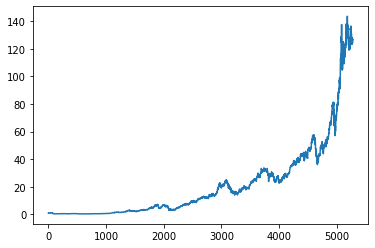

In [7]:
import matplotlib.pyplot as plt

plt.plot(time, series)

In [8]:
split_point = 4800
train_data = series[:split_point]
train_time = time[:split_point]
test_data = series[split_point:]
test_time = time[split_point:]

In [9]:
def windowed_data(series, batch_size, window_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [10]:
training_data = windowed_data(series, batch_size=42, window_size=30, shuffle_buffer=1000)

In [11]:
print(training_data)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [27]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='causal', input_shape=[None, 1], activation='relu'),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])

history = model.fit(training_data, epochs=25)

Epoch 1/25
126/126 [==============================] - 18s 104ms/step - loss: 23.5880 - mse: 23.5880
Epoch 2/25
126/126 [==============================] - 13s 104ms/step - loss: 6.5329 - mse: 6.5329
Epoch 3/25
126/126 [==============================] - 13s 104ms/step - loss: 42.3719 - mse: 42.3719
Epoch 4/25
126/126 [==============================] - 13s 104ms/step - loss: 11.8493 - mse: 11.8493
Epoch 5/25
126/126 [==============================] - 13s 104ms/step - loss: 15.8157 - mse: 15.8157
Epoch 6/25
126/126 [==============================] - 13s 104ms/step - loss: 10.3898 - mse: 10.3898
Epoch 7/25
126/126 [==============================] - 13s 103ms/step - loss: 7.1699 - mse: 7.1699
Epoch 8/25
126/126 [==============================] - 13s 104ms/step - loss: 7.4220 - mse: 7.4220
Epoch 9/25
126/126 [==============================] - 13s 104ms/step - loss: 3.4464 - mse: 3.4464
Epoch 10/25
126/126 [==============================] - 13s 104ms/step - loss: 3.3496 - mse: 3.3496
Epoch 11/

In [28]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [29]:
window_size=30

In [30]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_point - window_size:-1, 0]

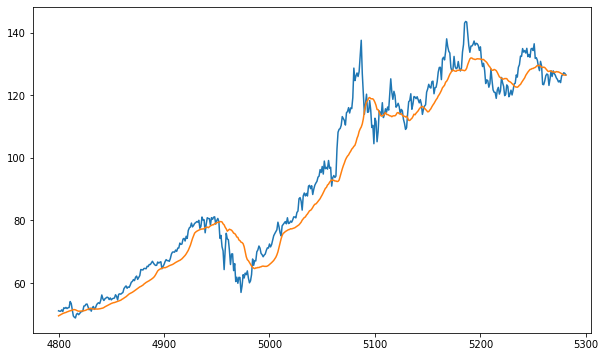

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(test_time, test_data)
plt.plot(test_time, rnn_forecast)